# Hate Speech Detection in Turkish with LLM Kanarya

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech/Subtask_A/tr_gr_train.csv
/kaggle/input/hate-speech/Subtask_A/refugee_train.csv
/kaggle/input/hate-speech/Subtask_A/isr_pal_train.csv
/kaggle/input/hate-speech/Subtask_A/.ipynb_checkpoints/isr_pal_train-checkpoint.csv
/kaggle/input/hate-speech/Subtask_A/.ipynb_checkpoints/refugee_train-checkpoint.csv
/kaggle/input/hate-speech/Subtask_A/.ipynb_checkpoints/tr_gr_train-checkpoint.csv
/kaggle/input/hate-speech/Subtask_A/test/TaskA_withoutLabels.csv
/kaggle/input/hate-speech/Subtask_A/test/TaskA_sampleSubmission.csv
/kaggle/input/hate-speech/Subtask_A/test/.ipynb_checkpoints/TaskA_withoutLabels-checkpoint.csv
/kaggle/input/hate-speech/Subtask_A/test/.ipynb_checkpoints/TaskA_sampleSubmission-checkpoint.csv
/kaggle/input/adv-hate-spch/adv_df_refugee_train.csv
/kaggle/input/adv-hate-spch/adv_df_tr_gr_train.csv
/kaggle/input/adv-hate-spch/adv_df_isr_pal_train.csv


In [2]:
# Install Pytorch & other libraries
!pip install "torch==2.2.1" tensorboard

# Install Hugging Face libraries
!pip install  --upgrade \
  "transformers==4.36.2" \
  "datasets==2.16.1" \
  "accelerate==0.26.1" \
  "evaluate==0.4.1" \
  "bitsandbytes==0.42.0" \
  # "trl==0.7.10" # \
  # "peft==0.7.1" \

# install peft & trl from github
!pip install git+https://github.com/huggingface/trl@a3c5b7178ac4f65569975efadc97db2f3749c65e --upgrade
!pip install git+https://github.com/huggingface/peft@4a1559582281fc3c9283892caea8ccef1d6f5a4f --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 66.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━

In [107]:
# import the required libraries
import os
import torch
import string
import pandas as pd
import numpy as np
from pprint import pprint
from random import randrange
from functools import partial

from sklearn.model_selection import train_test_split

import re

from torch.utils.data import DataLoader
import datasets # !pip install datasets
from datasets import load_dataset, Dataset

from transformers import AutoConfig
from peft import LoraConfig, PeftModel, TaskType

# tokenizers
from transformers import (
                          GPTJForSequenceClassification,
                          AutoModelForSequenceClassification,
                          AutoTokenizer,
                          Trainer,
                          DataCollatorWithPadding,
                          AutoModelForCausalLM,
                          BitsAndBytesConfig,
                          DataCollatorForLanguageModeling,
                          EarlyStoppingCallback,
                          TrainingArguments,
                          HfArgumentParser,
                          pipeline,
                          logging,
                          set_seed
                          )

import bitsandbytes as bnb
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, AutoPeftModelForCausalLM
from trl import SFTTrainer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             classification_report,
                             confusion_matrix,
                             precision_recall_fscore_support,
                             )

import evaluate
from evaluate import load


In [5]:
df_tr_gr_train = pd.read_csv("/kaggle/input/adv-hate-spch/adv_df_tr_gr_train.csv")
df_refugee_train = pd.read_csv("/kaggle/input/adv-hate-spch/adv_df_refugee_train.csv")
df_isr_pal_train = pd.read_csv("/kaggle/input/adv-hate-spch/adv_df_isr_pal_train.csv")

In [6]:
df_train = pd.concat([df_tr_gr_train, df_isr_pal_train, df_refugee_train], ignore_index=True)
df_train.head()

,id,text,label
0,1568524118357864451,yunan ülke işgal et namus tecavüz et o ağız si...,1
1,1527761356061134851,neslihan düşünce doğru konu yanlış yer ukrayna...,0
2,1503008593372749826,adalar silah savaş sebep tabi öncelik diplomas...,0
3,1568255642095296513,murat izmir gavur de keşke yunan kazan de erme...,1
4,1525787544083910656,bugün yıl önce izmir o yunan işgal birlik ilk ...,0


In [7]:
print(df_train["text"].iloc[0], df_train["label"].iloc[0], "\n")
print(df_train["text"].iloc[1000], df_train["label"].iloc[1000], "\n")
print(df_train["text"].iloc[2000], df_train["label"].iloc[2000], "\n")
print(df_train["text"].iloc[3000], df_train["label"].iloc[3000] , "\n")
print(df_train["text"].iloc[4000], df_train["label"].iloc[4000], "\n")

yunan ülke işgal et namus tecavüz et o ağız sit deniz dök de osmanlı sene güç acı 1 

incil ilk emir sev tevrat ilk emir yaşa kuran keri ilk emir sev yahudi yaşa müslüman oku 0 

allah bela ver vuru filistin öl insan 1 

ateşkes ardından gazze 0 

eser şehit allah ne inan asker ne inan rahmet eyle el kol tut sağlam sudiye eğitim ver silah mermi ver o kullan ön saf din kardeş sonuç yap bu 0 



In [8]:
# emojiler
print(df_train["text"].iloc[1200], df_train["label"].iloc[1200] , "\n")

baş avrupa ülke ol üzere dünya antisemitizm art israil asker gayr insani hukuk dış davran sonuç sebep 0 



In [9]:
concated_dataset = pd.concat([df_tr_gr_train, df_refugee_train, df_isr_pal_train], ignore_index=True)
concated_dataset

,id,text,label
0,1568524118357864451,yunan ülke işgal et namus tecavüz et o ağız si...,1
1,1527761356061134851,neslihan düşünce doğru konu yanlış yer ukrayna...,0
2,1503008593372749826,adalar silah savaş sebep tabi öncelik diplomas...,0
3,1568255642095296513,murat izmir gavur de keşke yunan kazan de erme...,1
4,1525787544083910656,bugün yıl önce izmir o yunan işgal birlik ilk ...,0
...,...,...,...
8460,1393434648647192577,sponsor şeytan ol katil siyonist işgal israil ...,1
8461,1515487032570789894,mübarek gün hürmet özgür ilk kıble allah,0
8462,1391751856884523008,bugün ibadethane sal yalnızca ibadet yerine ge...,0
8463,1514963851342663684,kurşun at işle ! çocuk korkut çalış kork ! kad...,1


In [10]:
concated_dataset = concated_dataset.drop_duplicates('text')
concated_dataset

,id,text,label
0,1568524118357864451,yunan ülke işgal et namus tecavüz et o ağız si...,1
1,1527761356061134851,neslihan düşünce doğru konu yanlış yer ukrayna...,0
2,1503008593372749826,adalar silah savaş sebep tabi öncelik diplomas...,0
3,1568255642095296513,murat izmir gavur de keşke yunan kazan de erme...,1
4,1525787544083910656,bugün yıl önce izmir o yunan işgal birlik ilk ...,0
...,...,...,...
8459,1393654946936107008,uyan bedr aslan yad çağır kafkas kartallar söy...,0
8460,1393434648647192577,sponsor şeytan ol katil siyonist işgal israil ...,1
8461,1515487032570789894,mübarek gün hürmet özgür ilk kıble allah,0
8462,1391751856884523008,bugün ibadethane sal yalnızca ibadet yerine ge...,0


In [11]:
concated_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7738 entries, 0 to 8463
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7738 non-null   int64 
 1   text    7737 non-null   object
 2   label   7738 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 241.8+ KB


In [12]:
concated_dataset["text"].isnull().sum()

1

In [13]:
empty_counts = concated_dataset["text"].eq('').sum()
print(empty_counts)

0


In [14]:
concated_dataset = concated_dataset.dropna()
concated_dataset

,id,text,label
0,1568524118357864451,yunan ülke işgal et namus tecavüz et o ağız si...,1
1,1527761356061134851,neslihan düşünce doğru konu yanlış yer ukrayna...,0
2,1503008593372749826,adalar silah savaş sebep tabi öncelik diplomas...,0
3,1568255642095296513,murat izmir gavur de keşke yunan kazan de erme...,1
4,1525787544083910656,bugün yıl önce izmir o yunan işgal birlik ilk ...,0
...,...,...,...
8459,1393654946936107008,uyan bedr aslan yad çağır kafkas kartallar söy...,0
8460,1393434648647192577,sponsor şeytan ol katil siyonist işgal israil ...,1
8461,1515487032570789894,mübarek gün hürmet özgür ilk kıble allah,0
8462,1391751856884523008,bugün ibadethane sal yalnızca ibadet yerine ge...,0


In [15]:
concated_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7737 entries, 0 to 8463
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7737 non-null   int64 
 1   text    7737 non-null   object
 2   label   7737 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 241.8+ KB


### Test Train Split

In [16]:
concated_dataset.to_csv('hate_classification.csv', index=False)

In [17]:
dataset_name = "/kaggle/working/hate_classification.csv"

In [18]:
concated_dataset = load_dataset("csv", data_files = dataset_name, split = "train", keep_default_na=False).shuffle().select(range(1000))
concated_dataset

Generating train split: 0 examples [00:00, ? examples/s]

/opt/conda/lib/python3.10/site-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 1000
})

In [19]:
concated_dataset = concated_dataset.train_test_split(test_size=300/1000)
concated_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 700
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 300
    })
})

In [20]:
data = concated_dataset['train'].train_test_split(train_size=0.8, seed=42)

data['val'] = data.pop("test")

data['test'] = concated_dataset['test']

In [21]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 560
    })
    val: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 140
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 300
    })
})

In [22]:
data['train'].to_pandas().info()
data['val'].to_pandas().info()
data['test'].to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      560 non-null    int64 
 1   text    560 non-null    object
 2   label   560 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 13.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      140 non-null    int64 
 1   text    140 non-null    object
 2   label   140 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      300 non-null    int64 
 1   text    300 non-null    object
 2   label   300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ 

**As the classes are not balanced, we will compute the positive and negative weights and use them for loss calculation later:**

In [23]:
data['train'].to_pandas()["label"].value_counts()

label
0    385
1    175
Name: count, dtype: int64

In [24]:
pos_weights = len(data['train'].to_pandas()) / (2 * data['train'].to_pandas().label.value_counts()[1])
neg_weights = len(data['train'].to_pandas()) / (2 * data['train'].to_pandas().label.value_counts()[0])

pos_weights, neg_weights

(1.6, 0.7272727272727273)

In [25]:
data['train'][0]

{'id': 1414234688898666498,
 'text': 'eser söz başkan sistem sonuç dolar gel günlük afgan mülteci sayı bini geç herşey hergün zam',
 'label': 0}

### Tokenizing and Loading the Kanarya Model

In [26]:
checkpoint = "asafaya/kanarya-750m"

In [27]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/589k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/370k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [28]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, return_tensors='pt')

In [29]:
tokenized_data = data.map(preprocess_function, batched=True)
tokenized_data

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 560
    })
    val: Dataset({
        features: ['id', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 140
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 300
    })
})

In [30]:
tokenized_data = tokenized_data.remove_columns(["id", "text"])
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 560
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 140
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 300
    })
})

In [30]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [31]:
id2label = {1: "HATE", 0: "NoN-HATE"}
label2id = {"HATE": 1, "NoN-HATE": 0}

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2, id2label=id2label, label2id=label2id
)

model.config.pad_token_id = model.config.eos_token_id

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

Some weights of GPTJForSequenceClassification were not initialized from the model checkpoint at asafaya/kanarya-750m and are newly initialized: ['score.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Setup the trainer

### Evaluation Metrics

In [33]:
accuracy = evaluate.load("accuracy")

In [34]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    #print(eval_pred)
    print("---------")
    #print(predictions)
    print("---------")

    # Eğer predictions bir demetse, bir diziye dönüştür
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    # Use argmax to get the predicted class
    predictions = np.argmax(predictions, axis=1)
    # Compute and return the accuracy

    print("---------\n\n\n")

    return accuracy.compute(predictions=predictions, references=labels)


In [36]:
def compute_metrics(p):

    predictions, labels = p
    
    predictions = predictions[0]
    
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

## Custom Trainer for Weighted Loss

We have an imbalanced distribution between positive and negative classes. We need to train our models with a weighted cross-entropy loss to account for that. The Trainer class doesn't support providing a custom loss as it expects to get the loss directly from the model's outputs.

So, we need to define our custom WeightedCELossTrainer that overrides the compute_loss method to calculate the weighted cross-entropy loss based on the model's predictions and the input labels

In [37]:
class WeightedCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # Get model's predictions
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([neg_weights, pos_weights], device=model.device, dtype=logits.dtype))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [38]:
training_args = TrainingArguments(
    output_dir="kanarya-lora-classification",
    learning_rate=2e-5,
    lr_scheduler_type="constant",
    warmup_ratio= 0.1,
    max_grad_norm= 0.3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_checkpointing=True,
)

"""
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
"""

kanarya_trainer = WeightedCELossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

kanarya_trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.

  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.693153,0.307143,0.144340,0.094337,0.307143
2,No log,0.693132,0.692857,0.567149,0.480051,0.692857


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

TrainOutput(global_step=70, training_loss=0.693188967023577, metrics={'train_runtime': 3672.5132, 'train_samples_per_second': 0.305, 'train_steps_per_second': 0.019, 'total_flos': 267957043200000.0, 'train_loss': 0.693188967023577, 'epoch': 2.0})

In [39]:
# Evaluate the model
results = kanarya_trainer.evaluate()
results

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.6931318044662476,
 'eval_accuracy': 0.6928571428571428,
 'eval_f1': 0.5671488848704039,
 'eval_precision': 0.4800510204081633,
 'eval_recall': 0.6928571428571428,
 'eval_runtime': 70.2382,
 'eval_samples_per_second': 1.993,
 'eval_steps_per_second': 0.128,
 'epoch': 2.0}

In [40]:
# Predictions to get the confusion matrix
predictions = kanarya_trainer.predict(tokenized_data['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

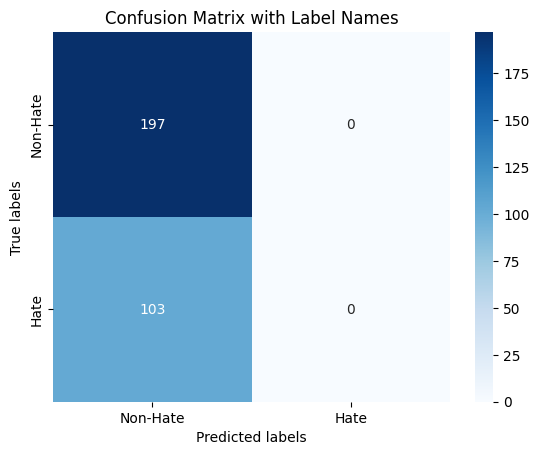

In [41]:
label_map = {
    'LABEL_0': 'Non-Hate',
    'LABEL_1': 'Hate'
}

cm = confusion_matrix(predictions.label_ids, preds)

# label_map to labels
labels = [label_map[f'LABEL_{i}'] for i in range(len(label_map))]

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Label Names')
plt.show()

Neden sadece 0 tahmini yapıyor eğitimsiz yapabiliyor 1 tahmini yapabiliyor. Eğitim az olduğu için mi böyle

### Base Model Without Training

In [68]:
data = load_dataset("csv", data_files = dataset_name, split = "train", keep_default_na=False).shuffle().select(range(1000))
data

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 1000
})

In [ ]:
checkpoint = "asafaya/kanarya-750m"A

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

In [35]:
straight_model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2, id2label=id2label, label2id=label2id
)

straight_model.config.pad_token_id = model.config.eos_token_id

Some weights of GPTJForSequenceClassification were not initialized from the model checkpoint at asafaya/kanarya-750m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
data

Dataset({
    features: ['id', 'text', 'label'],
    num_rows: 1000
})

In [71]:
texts = data["text"][:] # [11:15]
inputs = tokenizer(
        texts,
        truncation = True,
        padding=True,
        return_tensors="pt"
    )

print(len(inputs["input_ids"]))

1000


In [72]:
with torch.no_grad():
    logits = straight_model(**inputs).logits
    print(logits)

tensor([[1.0068e-04, 6.1966e-05],
        [8.2402e-05, 1.1153e-04],
        [3.4514e-05, 1.1082e-04],
        ...,
        [1.4299e-04, 1.2338e-04],
        [1.0987e-04, 1.0143e-04],
        [5.3884e-05, 1.0006e-04]])


In [74]:
logits[1]

tensor([8.2402e-05, 1.1153e-04])

In [101]:
y_pred = list()

for i in range(1000):
    predicted_class_id = logits[i].argmax().item()
    y_pred.append(predicted_class_id)
    

In [102]:
print(y_pred)

[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 

In [103]:
predicted_class_id = logits[1].argmax().item()
model.config.id2label[predicted_class_id]

'HATE'

In [105]:
y_true = data["label"]
print(y_true)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 

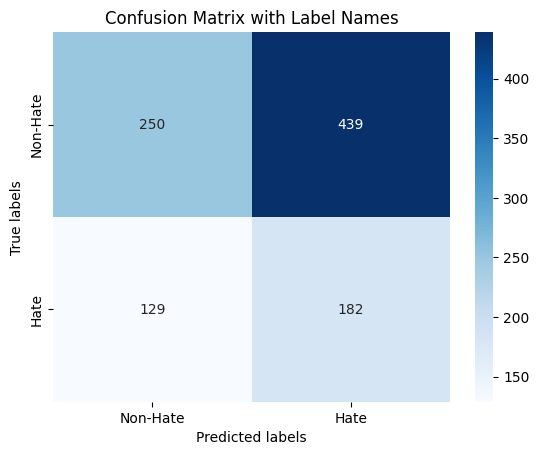

In [108]:
label_map = {
    'LABEL_0': 'Non-Hate',
    'LABEL_1': 'Hate'
}

cm = confusion_matrix(y_true, y_pred)

# label_map to labels
labels = [label_map[f'LABEL_{i}'] for i in range(len(label_map))]

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Label Names')
plt.show()

In [109]:
f1_score(y_true, y_pred, average='macro')

0.42936136696082683

In [110]:
f1_score(y_true, y_pred, average='micro')

0.432

In [111]:
f1_score(y_true, y_pred, average='weighted')

0.44402906238446577